E-commerce companies like AMazon , flipkart uses different recommendation systems to provide suggestions to the customers.

Amazon uses currently item-item collaberrative filtering, which scales to massive datasets and produces high quality recommendation system in the real time. This system is a kind of a information filtering system which seeks to predict the "rating" or preferences which user is interested in.

Attribute Information:

● userId : Every user identified with a unique id

● productId : Every product identified with a unique id

● Rating : Rating of the corresponding product by the corresponding user

● timestamp : Time of the rating ( ignore this column for this exercise)

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
electronics_data = pd.read_csv("/content/ratings_Electronics (1).csv",
names=['userId', 'productId','Rating','timestamp'])


In [ ]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [ ]:
electronics_data.shape

(103431, 4)

In [ ]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]


In [ ]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp    float64
dtype: object

In [ ]:
#Five point summary

electronics_data.describe()['Rating'].T


count    103430.000000
mean          4.042763
std           1.349894
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


### Handling Missing values


In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())



Number of missing values across columns: 
 userId       0
productId    0
Rating       1
timestamp    1
dtype: int64


### Ratings

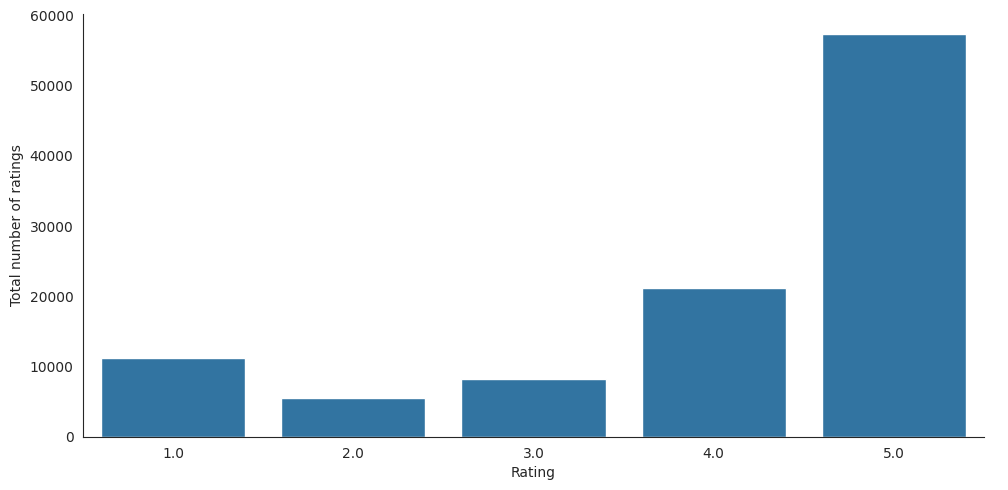

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="Rating", data=electronics_data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")


### Unique Users and products


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :", electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
# Convert productId column to string data type
electronics_data['productId'] = electronics_data['productId'].astype(str)
print("Total No of products  :", len(np.unique(electronics_data.productId)))


Total data 
--------------------------------------------------

Total no of ratings : 103431
Total No of Users   : 92798
Total No of products  : 7107


In [ ]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [ ]:
#Analysis of rating given by the user
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head(30)

userId
A231WM2Z2JL0U3    107
A2BGZ52M908MJY     51
AY8Q1X7G96HV5      37
A1MJMYLRTZ76ZX     34
A7Y6AVS576M03      31
A1NVD0TKNS1GT5     30
A1RPTVW5VEOSI      30
A3MEIR72XKQY88     27
ALUNVOQRXOZIA      26
AKT8TGIT6VVZ5      25
A243HY69GIAHFI     25
A23ZO1BVFFLGHO     24
A6FIAB28IS79       24
AN30G4IKL1BMZ      23
A2B7BUH8834Y6M     22
A2G2QNKDL1Y6AC     21
A1C8V13RD60LTR     20
AX04HWP70EXLD      19
A5JLAU2ARJ0BO      17
AT2J7H5TRZM8Z      17
A3TRPVAGT3NWBS     17
A2AEZQ3DGBBLPR     17
A3A15L96IYUO6V     17
A1ISUNUWG0K02V     16
A25HBO5V8S8SEA     16
A11D1KHM7DVOQK     16
A3PLX6PTM2ERKL     16
A1WVMDRJU19AFD     16
ARXU3FESTWMJJ      16
A3IBOQ8R44YG9L     16
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()


count    92798.000000
mean         1.114571
std          0.752350
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        107.000000
Name: Rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


- The quantile graph represents the distribution of the number of ratings given by users across different quantiles.

-  By analyzing the quantile graph, you can gain insights into how the number of ratings by users is distributed across different quantiles.

- For example, you can identify whether there are certain quantiles where users tend to give more ratings or if the distribution is relatively uniform across quantiles.

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

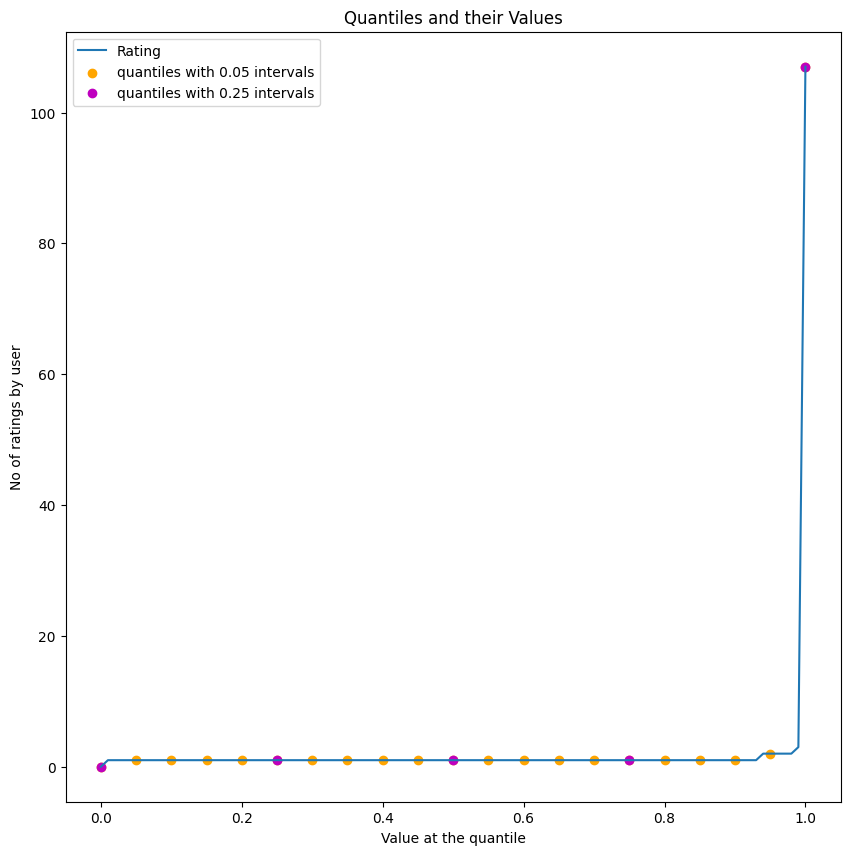

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 2



#Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, ''),
 Text(350.0, 0, ''),
 Text(400.0, 0, '')]

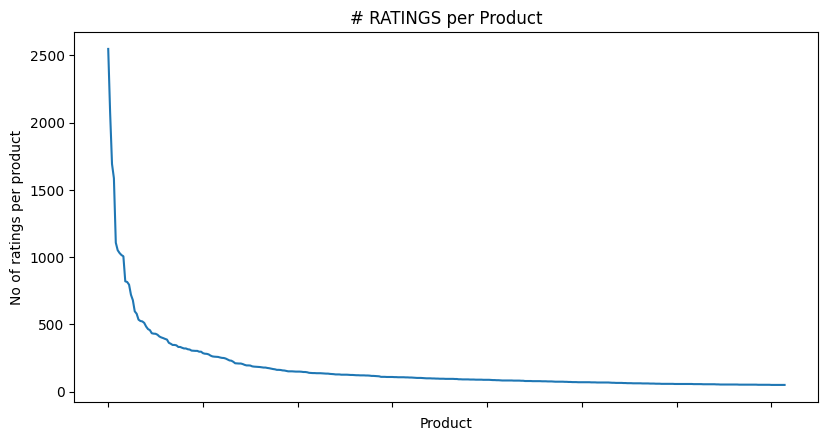

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
#Average rating of the product

new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head(20)

productId
B000053HC5    4.945783
B00005LE76    4.879310
B000053HH5    4.841499
B00004TDLD    4.840517
B00004TENT    4.823529
B00005LE77    4.815385
B00004Y2MM    4.808824
B00004XOM3    4.794613
B000053HBB    4.793651
B0000511U7    4.790055
B0000513US    4.771084
B00004Z5KA    4.754717
B000050LUE    4.754717
B0000513O4    4.737226
B00000J4EY    4.735294
B00004YMCA    4.728571
B00004TZE5    4.716216
B00005ABC5    4.715686
B00004TJ7O    4.714286
B00005108H    4.708861
Name: Rating, dtype: float64

In [ ]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B00004ZCJE    2547
B00001P4ZH    2075
B00004T8R2    1692
B00001WRSJ    1586
B00005LEN4    1107
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [ ]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [ ]:
ratings_mean_count['rating_counts'].max()


2547

1. Histogram of Rating Counts:

- This plot shows the distribution of the number of ratings given to products.

It helps visualize how many products have a specific number of ratings, providing insights into the popularity and engagement of products.

<Figure size 800x600 with 0 Axes>

<Axes: >

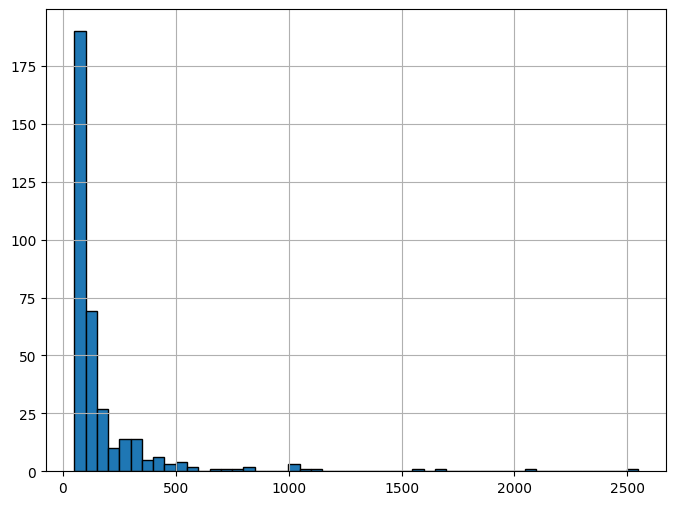

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

2. Histogram of Ratings:

- This plot shows the distribution of ratings given by users across all products.

It helps visualize the distribution of ratings, providing insights into the overall sentiment or satisfaction level of users towards products.

<Figure size 800x600 with 0 Axes>

<Axes: >

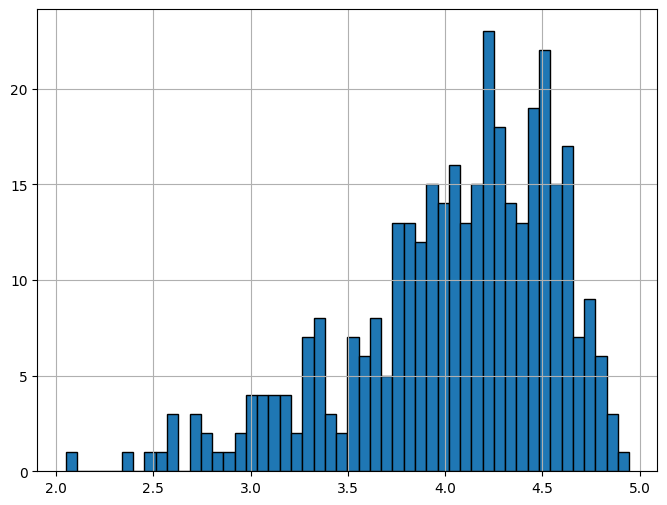

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

3. Bar Plot of Most Popular Products:

- This plot displays the top 30 most popular products based on the number of ratings they have received.

It helps identify the products that have received the highest number of ratings, indicating their popularity or level of user engagement.

<Axes: xlabel='productId'>

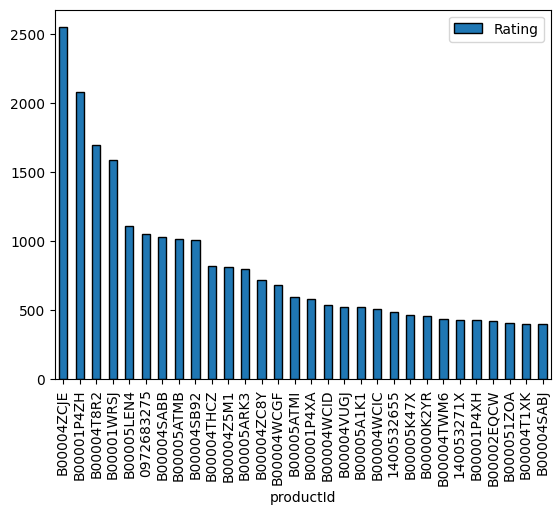

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaberative filtering (Item-Item recommedation) using KNN

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162740 sha256=2ee3d49c368d300cce0424b6fc9e7505f87a083ac2d7d44c0b4d9793f60d4801
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred


[Prediction(uid='A2RM5Z9LO295E6', iid='B00004VUGJ', r_ui=1.0, est=4.128332271858794, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1HAOL448R96L9', iid='B00005LEN4', r_ui=5.0, est=4.128332271858794, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3AFPQWM1RGSDE', iid='B00001W0EQ', r_ui=5.0, est=4.128332271858794, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A12NYW41LVDZIZ', iid='B00003CWDH', r_ui=5.0, est=4.128332271858794, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A37M4TFEIWIL5W', iid='B00005ATMB', r_ui=5.0, est=4.128332271858794, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A20OX8QD0LPQOF', iid='B00004ZCKV', r_ui=4.0, est=4.128332271858794, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A33QBULPCAI

In [ ]:
import pandas as pd
from surprise import Dataset, Reader

# Assuming you have a DataFrame named unseen_df with columns 'userID', 'itemID', and 'rating'
unseen_df = pd.DataFrame({
    'userID': ['user1', 'user2', 'user3'],
    'itemID': ['item1', 'item2', 'item3'],
    'rating': [5, 4, 3]
})

# Assuming reader and algo are already defined as in your code

# Convert the DataFrame to a Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(unseen_df[['userID', 'itemID', 'rating']], reader)

# Test the model against the new dataset
testset = data.build_full_trainset().build_testset()
predictions = algo.test(testset)

# Print predictions
for prediction in predictions:
    print(prediction)


user: user1      item: item1      r_ui = 5.00   est = 4.13   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: user2      item: item2      r_ui = 4.00   est = 4.13   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: user3      item: item3      r_ui = 3.00   est = 4.13   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2942


1.2942163158729458

# Model-based collaborative filtering system

This creates a simplified table where users are listed in rows, products are listed in columns, and each cell contains the rating given by a user to a product.*italicized text*

In [ ]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head(20)

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0590501PZ7HOWJKBGQ4,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
A0641581307AKT5MAOU0Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A076219533YHEV2LJO988,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0821988FXKFYX53V4QG,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.shape


(9832, 76)

In [ ]:
X = ratings_matrix.T
X.head(20)

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
140053271X,0,0,0,0,0,0,0,3,5,0,...,0,0,0,0,0,0,0,0,0,0
1400532736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400599997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape


(76, 9832)

In [ ]:
X1 = X


In simple terms, the TruncatedSVD model decomposes the original ratings matrix into lower-dimensional matrices to capture latent factors representing underlying patterns in user-item interactions.

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

Text(0.5, 58.7222222222222, 'Items')

Text(95.72222222222221, 0.5, 'Items')

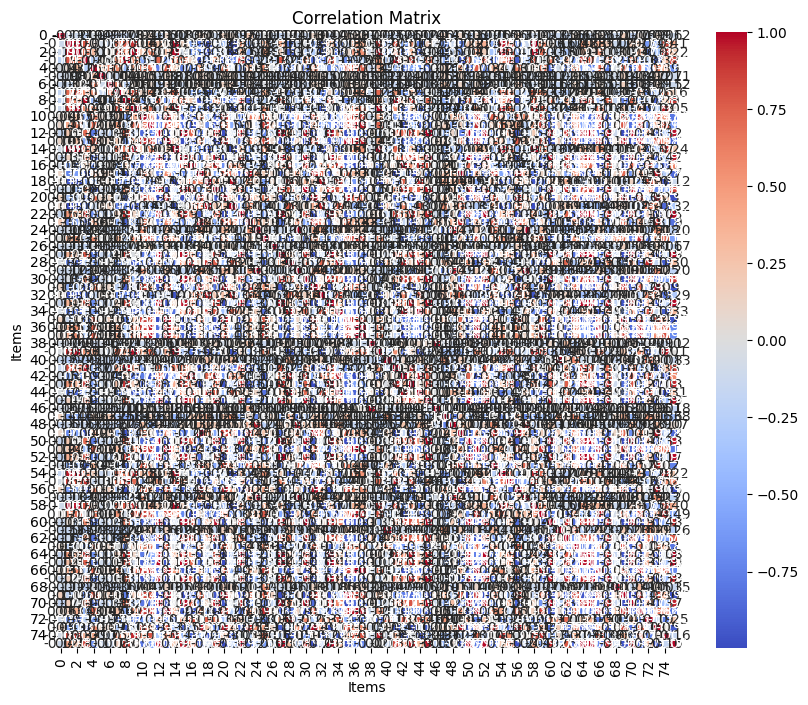

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.xlabel("Items")
plt.ylabel("Items")
plt.show()


In [ ]:
X.index[75]


'B00000K135'

Index # of product ID purchased by customer

In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 25 highly correlated products in sequence

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:24]

['1400501776',
 '1400599997',
 '7214047977',
 '9575871979',
 '9983891212',
 'B000001OM4',
 'B00000IGBF',
 'B00000J08Q',
 'B00000J0D8',
 'B00000J1SC',
 'B00000J1U8',
 'B00000J1V3',
 'B00000J434',
 'B00000J4FS',
 'B00000JD34',
 'B00000JDF6',
 'B00000JFE3',
 'B00000JFIF',
 'B00000JHWX',
 'B00000JMUG']